In [7]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import warnings

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
######################################   LOAD DATA:   ################################

df = pd.read_csv('data/in_Dataset')

df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.info()
print("Dataset size", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldBalanceOrig    float64
newBalanceOrig    float64
nameDest          object
oldBalanceDest    float64
newBalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Dataset size (6362620, 11)


In [9]:
####################################    DATA PREPROCESSING     ################################
##########################################  CLEAN DATA ########################################

#Relying on EDA, we must to:
#1 deal with umbalanced data
#2 work only with 'TRANSFER's and 'CASH_OUT' transaction
#3 Remove IsFlaggedFraud
#4 Remove Marchand from data
#5 Add new column for amount to deal with missing balnaces 

#print ('dataset size :%s'& df_clean.shape)

# 2 only two types of transactions occurs in fraud,So we assemble only the corresponding data in X for analysis
df_clean = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]


# fraud occurs only in customers who's name does not start with M
df_clean = df_clean[~df_clean.nameOrig.str.startswith('M') | ~df_clean.nameDest.str.startswith('M')]

# 3 Eliminate columns shown to be irrelevant for analysis in the EDA
# 4 Remove IsFlaggedFraud,it is meaningful because isFraud always set when IsFlaggedFraud is set
df_clean.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)


print("Dataset size", df_clean.shape)
df_clean.head()

Dataset size (2770409, 8)


,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [10]:
####################################    DATA PREPROCESSING     ################################
##################################### Features Engineering ####################################


#5 Add new column for amount to deal with missing balanaces => Features engineering

#There is some descrepancy in the data. oldBalanceSender - amount should equal newBalanceSender
# and oldBalanceReceiver + amount should equal newBalanceReceiver but doesn't always occur. create features
# and remove previous balance from both sender and receiver


df_feature = pd.DataFrame(df_clean)
df_feature['errorBalanceOrig'] = df_feature.newBalanceOrig + df_feature.amount - df_feature.oldBalanceOrig
df_feature['errorBalanceDest'] = df_feature.oldBalanceDest + df_feature.amount - df_feature.newBalanceDest
df_feature['noErrors'] = np.where((df_feature.errorBalanceOrig == 0) & (df_feature.errorBalanceDest == 0), 1, 0)
df_feature.drop(['oldBalanceOrig', 'oldBalanceDest'], 1, inplace=True)
df_feature = df_feature.rename(columns={'newBalanceOrig':'balanceSender', 'newBalanceDest':'balanceReceiver'})


#df_feature.dtypes

#change order of columns
df_feature = df_feature[['step', 'type','amount', 'balanceSender', 'balanceReceiver', 'errorBalanceDest','errorBalanceOrig','noErrors','isFraud']]


print("Dataset size", df_feature.shape)
df_feature.head()

Dataset size (2770409, 9)


,step,type,amount,balanceSender,balanceReceiver,errorBalanceDest,errorBalanceOrig,noErrors,isFraud
2,1,TRANSFER,181.00,0.0,0.00,181.0,0.00,0,1
3,1,CASH_OUT,181.00,0.0,0.00,21363.0,0.00,0,1
15,1,CASH_OUT,229133.94,0.0,51513.44,182703.5,213808.94,0,0
19,1,TRANSFER,215310.30,0.0,0.00,237735.3,214605.30,0,0
24,1,TRANSFER,311685.89,0.0,2719172.89,-2401220.0,300850.89,0,0


In [11]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 9 columns):
step                int64
type                object
amount              float64
balanceSender       float64
balanceReceiver     float64
errorBalanceDest    float64
errorBalanceOrig    float64
noErrors            int32
isFraud             int64
dtypes: float64(5), int32(1), int64(2), object(1)
memory usage: 200.8+ MB


In [12]:
#Save cleaned data
df_feature.to_csv('data/cleanedData.csv', index=False)

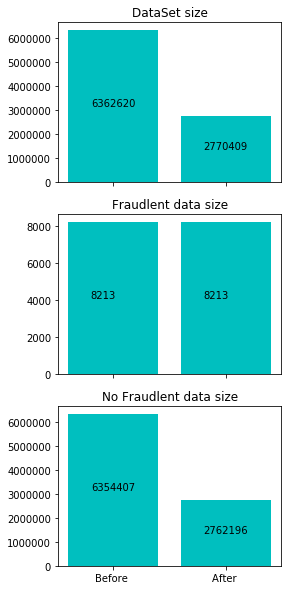

In [196]:
####################################    DATA Visualization     ################################
    ######################################## Size ########################################

f, ax = plt.subplots(3, sharex=True)

def plotSize(ax,before,after,t):
    b=ax.bar(['Before ', 'After '], [before,after],color='c')
    ax.set_title(t)
    ax.text(b[0].get_x()+0.2,b[0].get_height()/2,'%d' % int(before))
    ax.text(b[1].get_x()+0.2,b[1].get_height()/2,'%d' % int(after))

#totale size of dataset
before=len(df)
after=len(df_feature)
plotSize(ax[0],before,after,'DataSet size')

#totale size of Fraud records
before=len(df.loc[(df.isFraud == 1)])
after=len(df_feature.loc[(df_feature.isFraud == 1)])
plotSize(ax[1],before,after,'Fraudlent data size')

#totale size of not Fraud records
before=len(df.loc[(df.isFraud == 0)])
after=len(df_feature.loc[(df_feature.isFraud == 0)])
plotSize(ax[2],before,after,"No Fraudlent data size")

f.set_figheight(10)
f.set_figwidth(4)
plt.show()

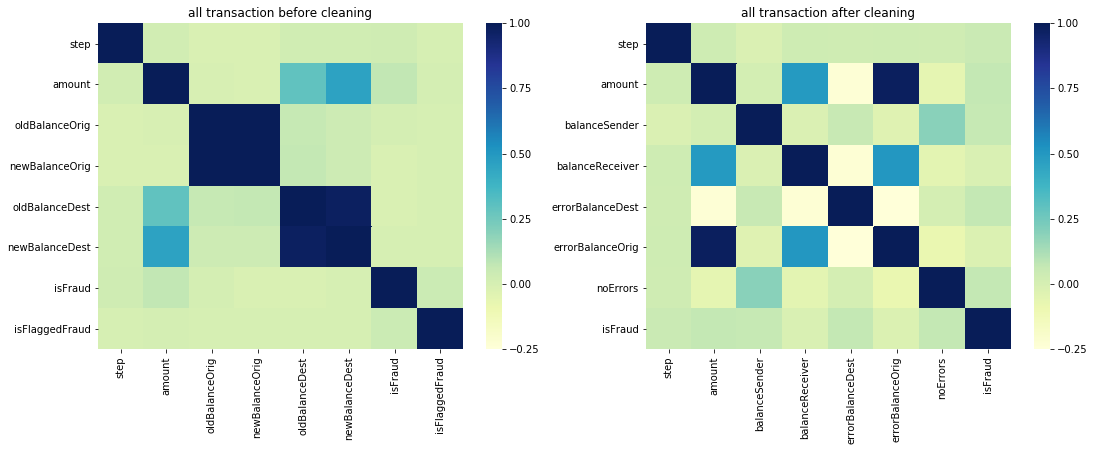

In [197]:
####################################    DATA Visualization     ################################
    ######################################## Correlation all transaction  ########################################

f, ax = plt.subplots(1,2)

#Feature correlation before all transaction
g1=sns.heatmap(df.corr(), vmin=-.25,cmap="YlGnBu",ax=ax[0])
g1.set_title('all transaction before cleaning')

#Feature correlation before all transaction
g1=sns.heatmap(df_feature.corr(), vmin=-.25,cmap="YlGnBu",ax=ax[1])
g1.set_title('all transaction after cleaning')

f.set_figheight(6)
f.set_figwidth(18)
plt.show()

In [198]:
X = df_feature.copy()
Y = df_feature['isFraud']
del X['isFraud']


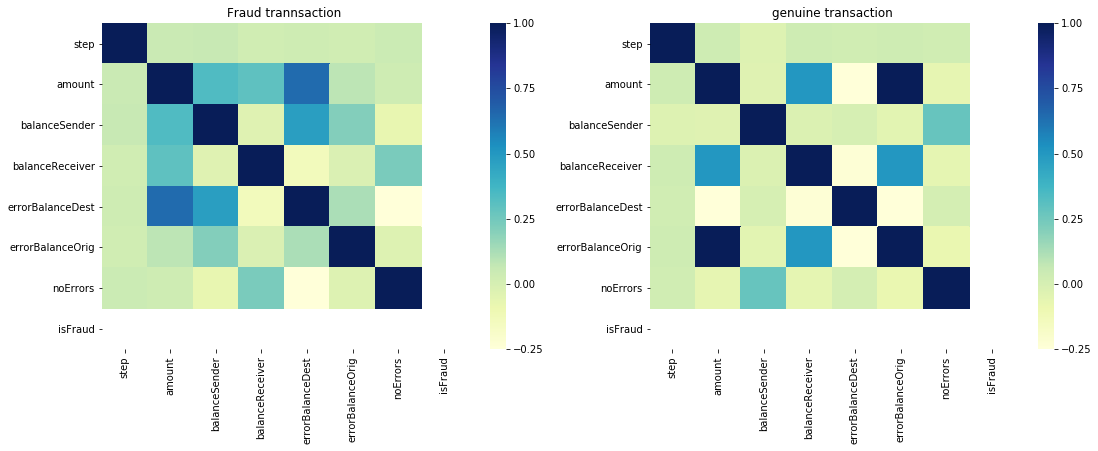

In [199]:
####################################    DATA Visualization     ################################
    ######################################## Correlation all transaction  ########################################

f, ax = plt.subplots(1,2, sharex=True)
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

#Feature correlation before all transaction
g1=sns.heatmap(Xfraud.corr(), vmin=-.25,cmap="YlGnBu",ax=ax[0])
g1.set_title('Fraud trannsaction')

#Feature correlation before all transaction
g1=sns.heatmap(XnonFraud.corr(), vmin=-.25,cmap="YlGnBu",ax=ax[1])
g1.set_title('genuine transaction')

f.set_figheight(6)
f.set_figwidth(18)
plt.show()

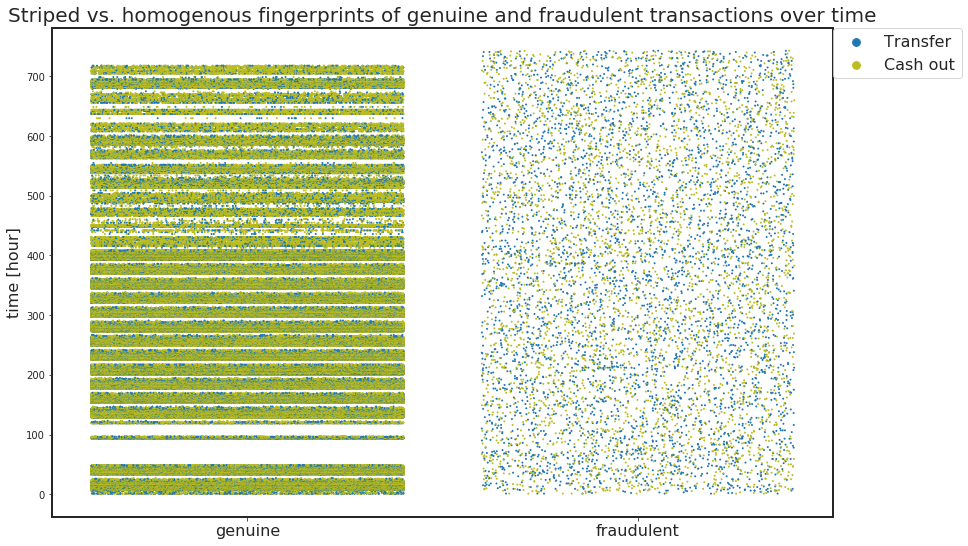

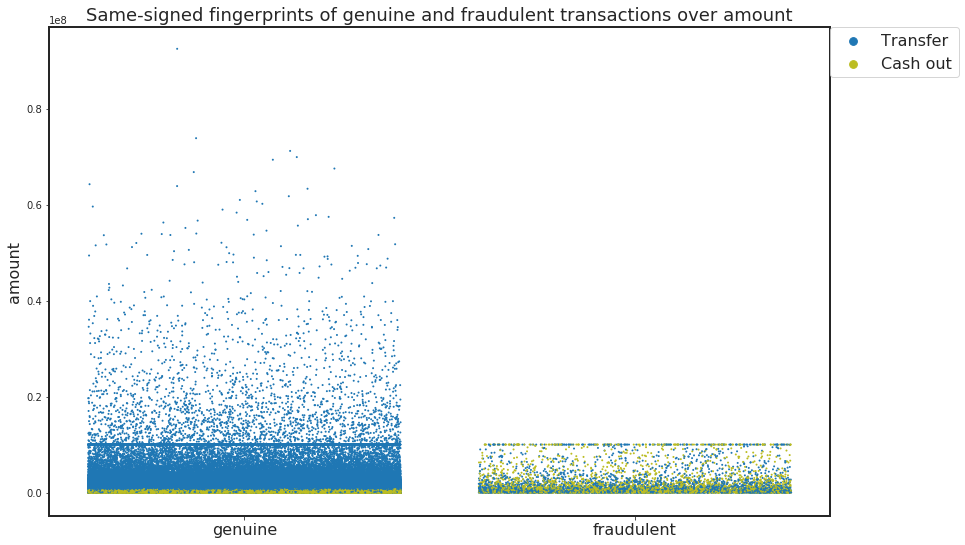

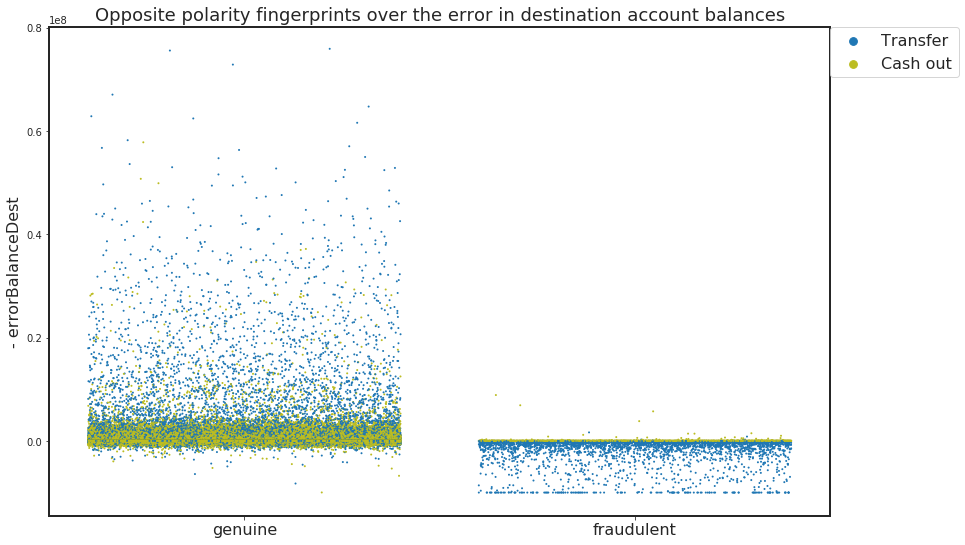

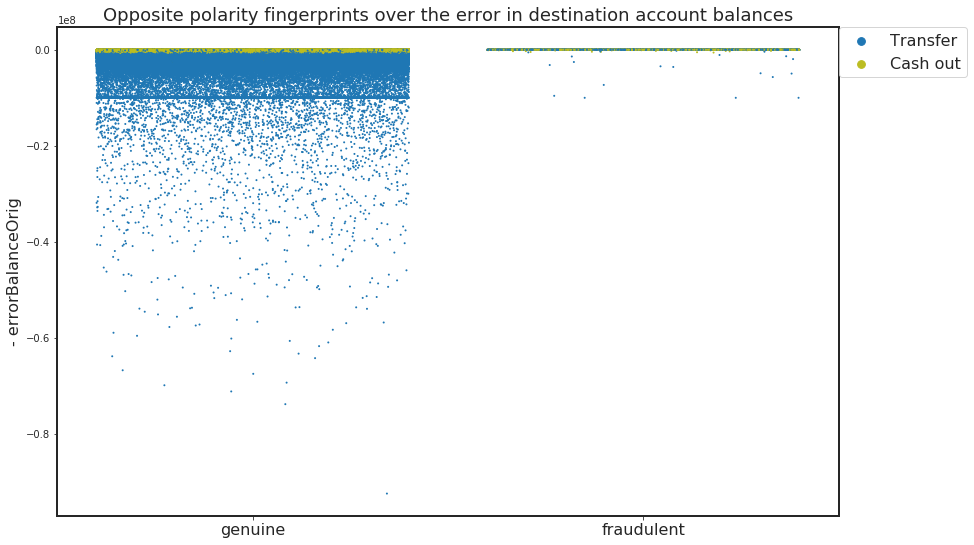

In [200]:
####################################    DATA Visualization     ################################
    ######################################## Information ##################################

#Is our data contains enough information so that a ML algorithm can make strong predictions

limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 5, 7))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

#Dispersion over time
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

#Dispersion over amount
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

#Dispersion over error in balance in destination accounts
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

ax = plotStrip(Y[:limit], - X.errorBalanceOrig[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('- errorBalanceOrig', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);


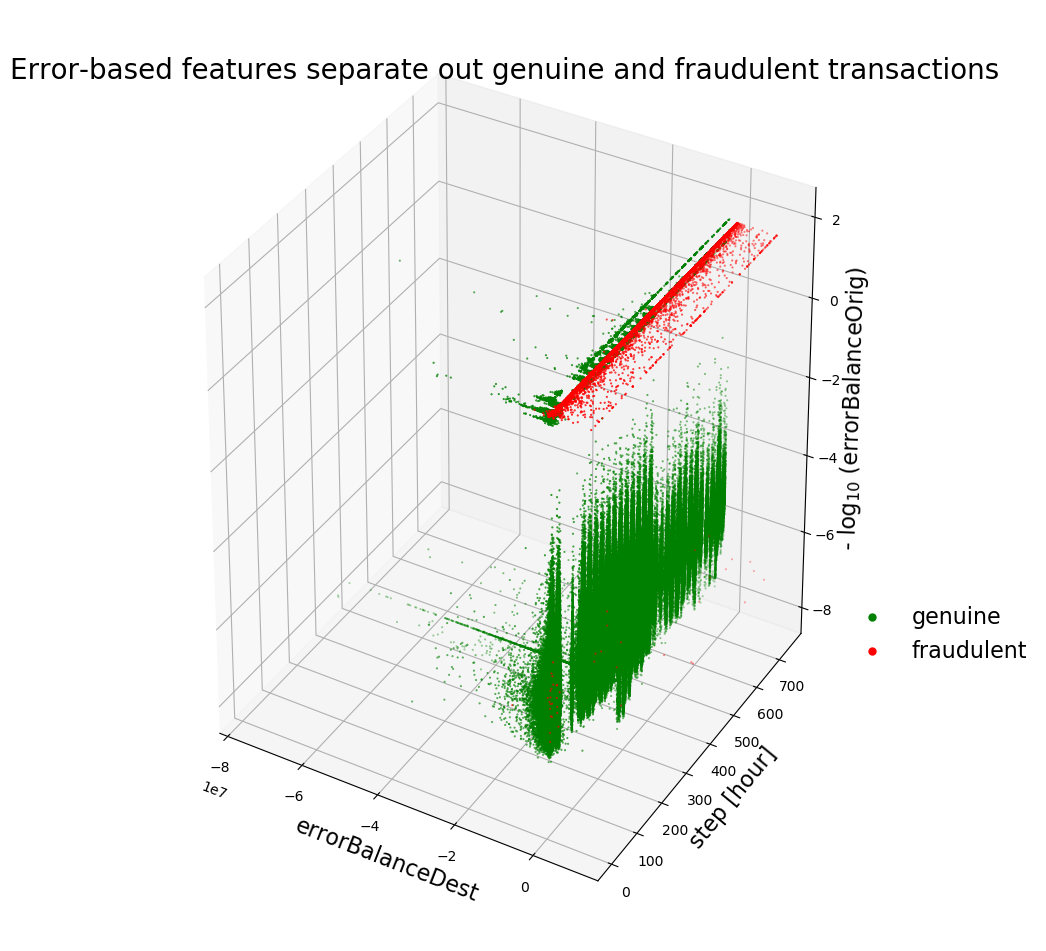

In [201]:
####################################    DATA Visualization     ################################
    ######################################## Information ##################################

#Separating out genuine from fraudulent transactions
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit],-np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit],-np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.', markersize = 10, label='fraudulent')
plt.legend(handles = [noFraudMarker, fraudMarker], bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

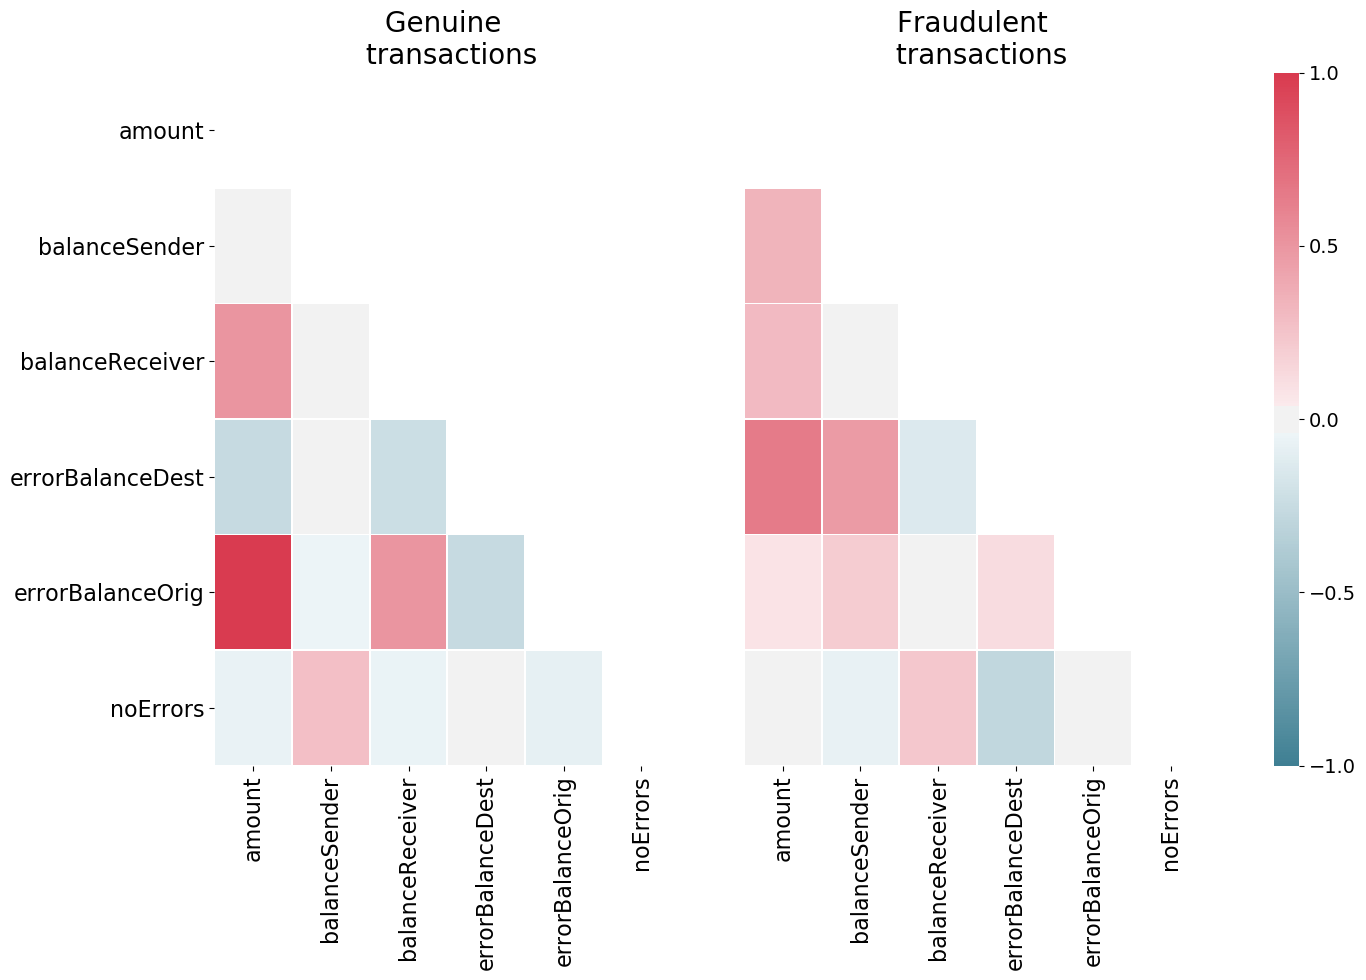

In [202]:
####################################    DATA Visualization     ################################
    ######################################## Information ##################################

#Fingerprints of genuine and fraudulent transactions
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);